Датасет с фильмами: https://grouplens.org/datasets/movielens/

In [21]:
import numpy as np
import pandas as pd
import time

ratings_df = pd.read_csv('./ratings.csv')
print('Количество пользователей: {}'.format(len(ratings_df['userId'].unique())))
print('Количество фильмов: {}'.format(len(ratings_df['movieId'].unique())))
print('Размерность датасета: {}'.format(ratings_df.shape))

ratings_df.head()

Количество пользователей: 610
Количество фильмов: 9724
Размерность датасета: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [30]:
# Отберём для тестирования часть набора и отмасштабируем для удобства идентификаторы фильмов так,
# чтобы они начинались с 1 и заканчивались на n_movies:

n = 100000
ratings_df_sample = ratings_df[:n]

n_users = len(ratings_df_sample['userId'].unique())
n_movies = len(ratings_df_sample['movieId'].unique())
(n_users, n_movies)


(610, 9569)

In [3]:
movie_ids = ratings_df_sample['movieId'].unique()

def scale_movie_id(movie_id):
    scaled = np.where(movie_ids == movie_id)[0][0] + 1
    return scaled

ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
ratings_df_sample.head()

C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\3425480383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,2,4.0,964981247
2,1,3,4.0,964982224
3,1,4,5.0,964983815
4,1,5,5.0,964982931


In [4]:
from sklearn.model_selection import train_test_split
# обучающий и тестовый наборы
train_data, test_data = train_test_split(ratings_df_sample, test_size=0.2)

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

# метрика RMSE (Root Mean Square Error, среднеквадратическая ошибка)

def rmse(prediction, ground_truth):
    # оставим оценки алгоритма только для соответствующего набора данных
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    # оставим оценки пользователя только для соответствующего набора данных
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    
    mse = mean_squared_error(prediction, ground_truth)
    return sqrt(mse)

In [6]:
# Сформируем матрицы размера (n_users, n_movies) для обучающего и тестового наборов, в которых
# элемент в ячейке [i, j] отражает оценку i-го пользователя j-му фильму
    
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [18]:
from  sklearn.metrics.pairwise import pairwise_distances
# ключевое в алгоритме -- мера близости
# считаем косинусное расстояние для пользователей и фильмов (построчно и поколоночно соотвественно)

# Valid values for metric are:
# [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
# [‘nan_euclidean’]
# [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’,
#  ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’,
#  ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’,
#  ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

# подходят евклидово, косинусное, корреляция 

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [14]:
# User-based collaborative filtering
def predict_user(top):
    # Структура для хранения для каждого пользователя оценки фильмов top наиболее похожих на него пользователей:
    # top_similar_ratings[0][1] - оценки всех фильмов одного из наиболее похожих пользователей на пользователя с ид 0.
    # Здесь 1 - это не ид пользователя, а просто порядковый номер.
    top_similar_ratings = np.zeros((n_users, top, n_movies))

    for i in range(n_users):
        # Для каждого пользователя необходимо получить наиболее похожих пользователей:
        # Нулевой элемент не подходит, т.к. на этом месте находится похожесть пользователя самого на себя
        top_sim_users = user_similarity[i].argsort()[1:top + 1]
        # берём только оценки из "обучающей" выборки 
        top_similar_ratings[i] = train_data_matrix[top_sim_users]

    pred = np.zeros((n_users, n_movies))
    for i in range(n_users):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred

pred_user = predict_user(9)
print('Основанная на пользователях фильтрация, RMSE: ', rmse(pred_user, test_data_matrix))

User-based CF RMSE:  3.529606918624226


In [44]:
def predict_item(top):
    top_similar_ratings = np.zeros((n_movies, top, n_users))

    for i in range(n_movies):
        top_sim_movies = item_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = train_data_matrix.T[top_sim_movies]
        
    pred = np.zeros((n_movies, n_users))
    for i in range(n_movies):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred.T

pred_item = predict_item(9)
print('Основанная на пользователях фильтрация, RMSE: ', rmse(pred_item, test_data_matrix))

Основанная на пользователях фильтрация, RMSE:  2.9471499624611175


In [ ]:
graph1 = []
graph2 = []
graph3 = []
axis_x = [j / 100 for j in range(10, 90, 5)]

for sup in axis_x:
    e_time1 = 0
    e_time2 = 0
    e_time3 = 0
    for i in range(10):
        start_time = time.time()
        for i in range(0, 100):
            apriori(df, min_support=sup)
        end_time = time.time()
        e_time1 += (end_time - start_time)

        start_time = time.time()
        for i in range(0, 100):
            eclat_instance.fit(min_support=sup, min_combination=1, max_combination=5, verbose=False)
        end_time = time.time()
        e_time2 += (end_time - start_time)

        start_time = time.time()
        for j in range(0, 100):
            fpgrowth(df, min_support=sup)
        end_time = time.time()
        e_time3 += (end_time - start_time)
    graph1.append(e_time1)
    graph2.append(e_time2)
    graph3.append(e_time3)

# разница между конечным и начальным временем

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

Время на инициализацию с метрикой cosine: 2.093982458114624 c
Время на инициализацию с метрикой euclidean: 1.4793601036071777 c
Время на инициализацию с метрикой correlation: 23.54092001914978 c


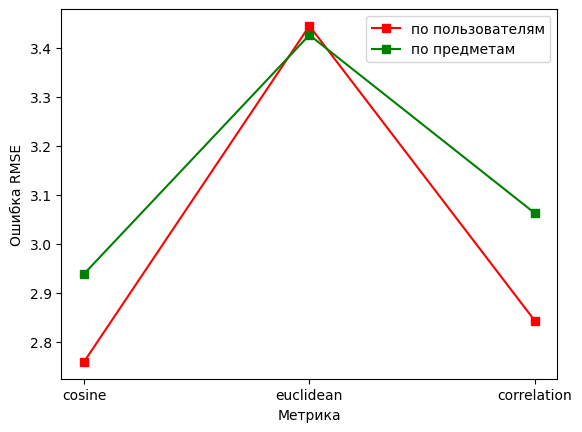

In [32]:
axis_x = ['cosine', 'euclidean', 'correlation']
graph1 = []
graph2 = []
graph01 = []
graph02 = []

for metr in axis_x:
    start_time = time.time()
    global user_similarity
    user_similarity = pairwise_distances(train_data_matrix, metric=metr)
    global item_similarity
    item_similarity = pairwise_distances(train_data_matrix.T, metric=metr)
    end_time = time.time()
    e_time = (end_time - start_time)
    print("Время на инициализацию с метрикой {}: {} c".format(metr, e_time))
    
    e_time1 = 0
    e_time2 = 0
    
    for i in range(10):
        start_time = time.time()
#         for i in range(0, 100):
        predict_user(9)
        end_time = time.time()
        e_time1 += (end_time - start_time)
        
        start_time = time.time()
#         for i in range(0, 100):
        predict_item(9)
        end_time = time.time()
        e_time2 += (end_time - start_time)
        
    graph1.append(e_time1 / 10)
    graph2.append(e_time2 / 10)
    
    pred_i = predict_item(9)
    pred_u = predict_user(9)
    
    graph01.append(rmse(pred_u, test_data_matrix))
    graph02.append(rmse(pred_i, test_data_matrix))

plt.plot(axis_x, graph01, marker='s', color='r', label="по пользователям");
plt.plot(axis_x, graph02, marker='s', color='g', label="по предметам");
plt.legend()
plt.xlabel('Метрика')
plt.ylabel('Ошибка RMSE');

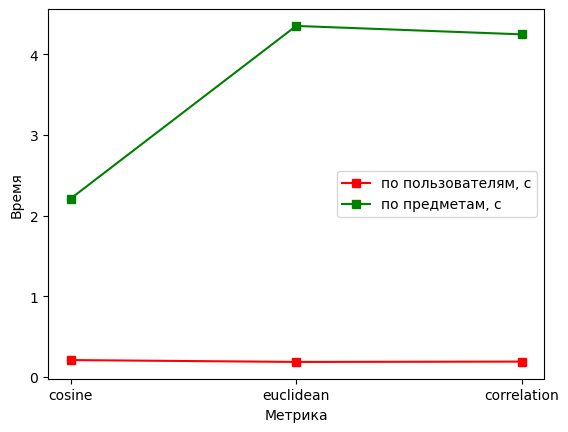

In [33]:
plt.plot(axis_x, graph1, marker='s', color='r', label="по пользователям, c");
plt.plot(axis_x, graph2, marker='s', color='g', label="по предметам, c");
plt.legend()
plt.xlabel('Метрика')
plt.ylabel('Время');

7 802
Время на инициализацию с n = 1000: 0.010001659393310547 c
32 2427


C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 5000: 0.11202526092529297 c
66 3218


C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 10000: 0.176039457321167 c
132 4841


C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 20000: 0.401090145111084 c
322 6908


C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 50000: 0.9192068576812744 c
610 9569


C:\Users\vikto\AppData\Local\Temp\ipykernel_16656\4001337800.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)


Время на инициализацию с n = 100000: 1.9949383735656738 c


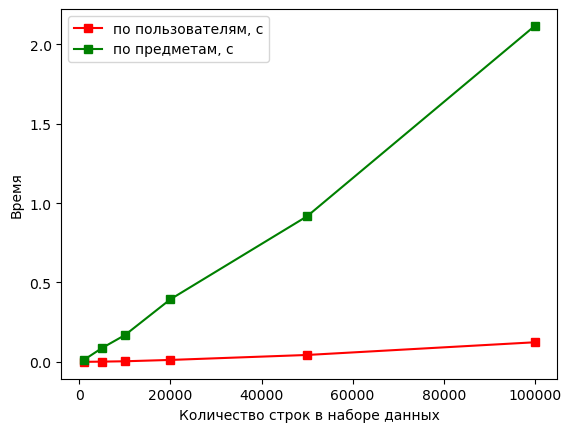

In [41]:
axis_x = ['cosine', 'euclidean', 'correlation']
graph1 = []
graph2 = []

ns = [1000, 5000, 10000, 20000, 50000, 100000]

for n in ns:
    global train_data_matrix
    global test_data_matrix
    global item_similarity
    global user_similarity
    
    ratings_df_sample = ratings_df[:n]
    n_users = len(ratings_df_sample['userId'].unique())
    n_movies = len(ratings_df_sample['movieId'].unique())
    print(n_users, n_movies)
    movie_ids = ratings_df_sample['movieId'].unique()
    ratings_df_sample['movieId'] = ratings_df_sample['movieId'].apply(scale_movie_id)
    train_data, test_data = train_test_split(ratings_df_sample, test_size=0.2)
    train_data_matrix = np.zeros((n_users, n_movies))
    for line in train_data.itertuples():
        train_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    test_data_matrix = np.zeros((n_users, n_movies))
    for line in test_data.itertuples():
        test_data_matrix[line[1] - 1, line[2] - 1] = line[3]
    
    start_time = time.time()
    user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
    item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
    end_time = time.time()
    e_time = (end_time - start_time)
    print("Время на инициализацию с n = {}: {} c".format(n, e_time))
    
    e_time1 = 0
    e_time2 = 0
    
    for i in range(10):
        start_time = time.time()
#         for i in range(0, 100):
        predict_user(5)
        end_time = time.time()
        e_time1 += (end_time - start_time)
        
        start_time = time.time()
#         for i in range(0, 100):
        predict_item(5)
        end_time = time.time()
        e_time2 += (end_time - start_time)
        
    graph1.append(e_time1 / 10)
    graph2.append(e_time2 / 10)

plt.plot(ns, graph1, marker='s', color='r', label="по пользователям, c");
plt.plot(ns, graph2, marker='s', color='g', label="по предметам, c");
plt.legend()
plt.xlabel('Количество строк в наборе данных')
plt.ylabel('Время');